In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (7,4)

Simulation de systèmes dynamiques non lisses
==============================


Le cours se focalise sur l'étude de systèmes dynamiques réguliers, c'est-à-dire $\dot{x}=f(x)$ avec $f$ au moins continue, et le plus souvent continûment différentiable. Le but de ce projet est de découvrir des systèmes moins réguliers, dits *non-lisses*. Il existe une myriade de modélisations de ces systèmes mais on peut distinguer différents *niveaux* d'irrégularité:

 - $f$ est continue mais non différentiable en certains points (on parle de *nonsmooth dynamics of type 1*, i.e., *NSD1*) : cela peut arriver dans la modélisation d'écoulements par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ restent $C^1$ mais leur simulation peut déjà se compliquer.

 - $f$ est discontinue en certains points, ou le long de certaines surfaces (on parle de *NSD2*) : ceci apparaît typiquement en mécanique lors de la modélisation de contacts et friction entre solides, ou dans la modélisation de circuits électriques contenant des diodes par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ sont toujours (absolument) continues mais non différentiables, le schéma numérique doit détecter des changements de *mode*.

 - les solutions $t\mapsto x(t)$ sont elles-mêmes discontinues, présentant des *sauts*  à certains instants ou lorsqu'elles rencontrent certaines surfaces, et il faut ajouter à $f$ un modèle de ces sauts (on parle de *NSD3*) : ceci apparaît typiquement avec les systèmes mécaniques à impact.

L'étude mathématique de ces sytèmes est très complexe, faisant appel à des outils qui nous mèneraient trop loin de ce cours (inclusions différentielles, complémentarité, analyse convexe, *measure differential inclusions*, etc), notre but est seulement d'en découvrir certains aspects à travers des exemples iconiques. Les curieux peuvent se référer à la documentation fournie par 

https://www.inria.fr/en/modelling-mechanics-simulation-fibres

https://www.inria.fr/en/tripop

ou aux ouvrages de références tels que

https://link.springer.com/book/10.1007/978-94-015-7793-9

https://link.springer.com/book/10.1007/978-3-540-44398-8 




## Dynamique non différentiable (NSD1)

Reprenons la loi de Toriccelli étudiée en TD et modélisant (modulo reparamétrisation) l'écoulement d'un fluide dans un réservoir
$$
\dot{x} = - \sqrt{|x|} \tag{1}
$$

**Question 1** Coder un schéma Euler explicite permettant de simuler une équation différentielle $\dot{x}=f(x,t)$ à partir d'une condition initiale $x_0$ au temps $t_0$ jusqu'au temps $t_f$ avec un pas de temps $dt$. 

In [4]:
def euler_explicite(f,x0,t0,tf,dt):
    time = [t0]
    sol = [x0]
    t = t0
    x = x0
    while t + dt <= tf :
        x += dt * f(x, t)
        sol.append(x)
        t += dt
        time.append(t)
    return time, sol


**Question 2** L'utiliser pour simuler un écoulement d'une hauteur initiale $x_0=10$ pendant 10 unités de temps. Tracer la solution obtenue. Est-elle celle que l'on attend ? Les solver ''odeint'' ou ''solve_ivp" de scipy fait-il mieux ? Expliquer pourquoi. Proposer une façon de simuler *la* solution *physique*.

---


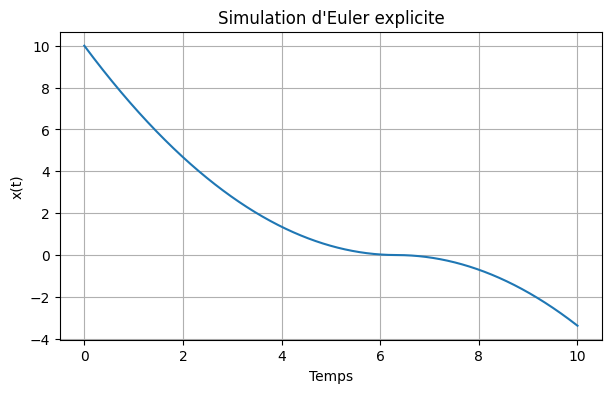

In [5]:
def f(x, t) :
    return -np.sqrt(abs(x))

dt = 10**(-5)
time, sol = euler_explicite(f, 10, 0, 10, dt)

plt.plot(time, sol)
plt.xlabel("Temps")
plt.ylabel("x(t)")
plt.title("Simulation d'Euler explicite")
plt.grid()
plt.show()

## ce n'est pas satisfaisant, car x devient négative après un certain temps,
## ce qui ne traduit pas le comportement réel de l'écoulement

## odeint et solve_ivp résolvent numériquement également ; odeint ne va pas résoudre le problème
## mais avec solve_ivp, on peut intégrer des événements, ce qui permettrait de conserver x >= 0

## pour simuler la solution physique, on peut ajouter dans la condition de la boucle while d'Euler que X >= 0
## ainsi, on peut retirer la valeur absolue de la définition de f et 
# dès que x = 0, on n'a pas x<0 mais on garde x = 0 jusqu'à t = 10

En pratique, on essaye toujours de se ramener à une modélisation *bien posée* dont les solutions existent et sont uniques (ajout de contraintes ou régularisation, par exemple). Ici, on pourrait par exemple considérer plutôt
$$
\dot{x} = - {\rm sign}(x) \sqrt{|x|} \tag{2}
$$
avec ${\rm sign}(0)$ arbitraire. 

**Question 3** Montrer que pour toute condition initiale dans $\mathbb{R}$, (2) admet une unique solution maximale en temps positif définie sur $\mathbb{R}_{\geq 0}$, et qu'elle correspond à la solution ``physique'' attendue précédemment pour des conditions initiales positives. Justifier que l'on parle de "convergence globale vers 0 en temps fini". Illustrer ce phénomène en simulation. Ce comportement serait-il possible pour $\dot{x}=f(x)$ avec $f$ continûment différentiable ?

---

**Réponse à question 3**

On considère
$$
\dot{x} = -{\rm sign}(x)\sqrt{|x|}\tag{2}
$$
avec ${\rm sign}(0)$ arbitraire.

On a $f$ continue sur $\mathbb{R}$ donc le théorème de Peano nous garantie l’existence de solutions au problème de Cauchy dans $\mathbb{R}$ pour toute condition initiale.
De plus
$$
|f(x,t)|=\sqrt{|x|}\le |x|+1 \qquad \forall x\in\mathbb{R},
$$
donc toute solution maximale est définie sur $\mathbb{R}_{+}$.

Soit $x$ une solution maximale. 
Soit $x(t_0)=x_0$.

Cas 1 : $x_0>0$

Tant que $x(t)>0$,
$$
\dot{x}=-\sqrt{x}.
$$
Donc :
$$\frac{\dot{x}}{\sqrt{x}} = -1 \quad \xrightarrow{\text{on intègre}} \quad x(t) = \left( \sqrt{x_0} - \frac{1}{2}(t - t_0) \right)^2$$
Cette expression s’annule au temps
$$t_1=t_0+2\sqrt{x_0}.$$

Cas 2 : $x_0<0$

Tant que $x(t)<0$, donc
$$\dot{x}=+\sqrt{-x}.$$
On sépare les variables :
$$\frac{\dot{x}}{\sqrt{-x}}=1\quad \xrightarrow{\text{on intègre}} \quad x(t)=-\left(\sqrt{-x_0}-\frac{1}{2}(t-t_0)\right)^2,$$
et cette expression s’annule au temps
$$t_1=t_0+2\sqrt{-x_0}=t_0+2\sqrt{|x_0|}.$$

Cas 3 : $x_0=0$

On a immédiatement $x(t)\equiv 0$.


On montre maintenant qu’à partir du moment où la solution atteint $0$, elle ne peut pas repartir.

On va supposer que $x_0>0$, l'autre cas se traite similairement. Soit $t_1$ le premier instant tel que $x(t_1)=0$ (on vient de voir que $t_1=t_0+2\sqrt{|x_0|}$).

Supposons par l’absurde qu’il existe $t_2>t_1$ tel que $x(t_2)<0$. considérons $t_3=\sup\{\,t2> t> t_1 \mid x(t)=0\,\}$. donc $\forall t \in ]t_3,t_2], x< 0$. Or dès que $x<0$, on a
$$
\dot{x}=\sqrt{-x}> 0,
$$
donc $x$ est croissante sur les portions où elle est négative. Comme $x(t_3)=0$, une fonction croissante juste après $t_3$ ne peut pas devenir strictement négative : absurde.

Ainsi, la seule possibilité est
$$
\forall t\ge t_1,\quad x(t)=0.
$$

On obtient donc, pour tout $x_0\in\mathbb{R}$, l’unique solution maximale en temps positif :
$$
x(t)=
\begin{cases}
\left(\sqrt{x_0}-\frac{1}{2}(t-t_0)\right)^2, & x_0>0,\ t\le t_0+2\sqrt{x_0},\\[6pt]
-\left(\sqrt{-x_0}-\frac{1}{2}(t-t_0)\right)^2, & x_0<0,\ t\le t_0+2\sqrt{-x_0},\\[6pt]
0, & t\ge t_0+2\sqrt{|x_0|},
\end{cases}
$$
et si $x_0=0$ alors $x(t)\equiv 0$.

En particulier, si $x_0>0$, la solution reste $\ge 0$, s’annule puis reste nulle : c’est exactement la solution physique attendue (réservoir qui se vide puis reste vide).

Pour tout $x_0\in\mathbb{R}$, on a un temps explicite
$$
T(x_0)=2\sqrt{|x_0|}
$$
tel que
$$
\forall t\ge t_0+T(x_0),\quad x(t)=0.
$$
C’est une convergence globale (valable pour toute condition initiale) vers $0$, et en temps fini (atteinte exacte de 0 en un temps fini).

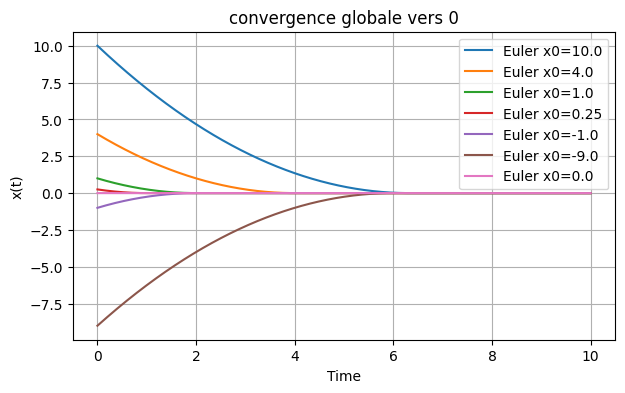

In [6]:
def f2(x, t):
    if x > 0:
        return -np.sqrt(x)
    if x < 0:
        return np.sqrt(-x)
    return 0.0

t0, tf, dt = 0.0, 10.0, 1e-3
x0_list = [10.0, 4.0, 1.0, 0.25, -1.0, -9.0, 0.0]

plt.figure()
for x0 in x0_list:
    time, sol = euler_explicite(f2, x0, t0, tf, dt)
    plt.plot(time, sol, label=f"Euler x0={x0}")

plt.xlabel("Time")
plt.ylabel("x(t)")
plt.title("convergence globale vers 0")
plt.grid(True)
plt.legend()
plt.show()

Ce comportement n'est pas nécessairement possible pour $\dot{x}=f(x)$ avec $f$ continûment différentiable.

Exemple:$$\dot{x}=-x$$

## Dynamique discontinue (NSD2)



Passons maintenant à une irrégularité plus forte, lorsque la fonction $f$ décrivant l'équation différentielle $\dot{x}=f(x)$ est discontinue, c'est-à-dire lorsque la solution $x$ suit des dynamiques différentes selon les régions de l'espace (par exemple selon le sens du courant pour des diodes, selon le sens de la vitesse pour des frottements secs etc.). Un exemple emblématique de ce cas de figure est 
$$
\dot{x} = - k {\rm sign}(x) \tag{3}
$$
pour $k>0$ et la valeur de ${\rm sign}(0)$ à définir. Dans ce contexte, on affaiblie la régularité des solutions recherchées, qui ne sont plus nécessairement $C^1$ sur leur intervalle de définition. Par contre, elles sont toujours censées vérifier l'équation intégrale 
$$
x(t) = x(t_0) + \int_{t_0}^t f(s,x(s)) ds
$$
et on considère donc la classe des solutions *absolument continues*, qui vérifient l'équation différentielle *pour presque tout $t$* seulement. 

---

**Question 4** Démontrer que pour une valeur de ${\rm sign}(0)$ bien choisie, (3) admet, pour toute condition initiale $x_0\in \mathbb{R}$, une unique solution maximale $t\mapsto x(t)$ en temps positif définie sur $\mathbb{R}_{\geq 0}$ et convergeant en temps fini vers 0. L'expliciter.

---


**Réponse à la question 4**

Pour ne pas avoir plusieur solution quand $x_0=0$, on va imposer que la solution unique soit la fonction nul. on choisit ${\rm sign}(0)=0$.

Si $x_0>0$, tant que $x(t)>0$ on a ${\rm sign}(x)=1$ donc $\dot{x}=-k$ et
$$
x(t)=x_0-kt
$$
jusqu’au premier temps $T=\frac{x_0}{k}$ où $x(T)=0$. Pour $t\ge T$, comme ${\rm sign}(0)=0$, l’équation donne $\dot{x}=0$ lorsque $x=0$, donc on obtient nécessairement $x(t)=0$.

Si $x_0<0$, tant que $x(t)<0$ on a ${\rm sign}(x)=-1$ donc $\dot{x}=+k$ et
$$
x(t)=x_0+kt
$$
jusqu’au premier temps $T=\frac{-x_0}{k}=\frac{|x_0|}{k}$ où $x(T)=0$, puis $x(t)=0$ pour $t\ge T$.


Ainsi, pour tout $x_0\in\mathbb{R}$, la solution en temps positif est
$$
x(t)={\rm sign}(x_0)\max\{0,|x_0|-kt\},
$$

L’unicité en temps positif vient du fait que si $x(t)>0$ alors forcément $\dot{x}=-k$ donc $x(t)$ est imposée, et si $x(t)<0$ alors forcément $\dot{x}=+k$ donc $x(t)$ est imposée; une fois $0$ atteint, le choix ${\rm sign}(0)=0$ impose $\dot{x}=0$ donc la solution reste à $0$.

---

Considérons maintenant $\delta_m>0$ et l'équation différentielle perturbée
$$
\dot{x} = - k{\rm sign}(x) + \delta(t) \tag{4}
$$
pour $t\mapsto \delta(t)$ telle que $|\delta(t)|\leq \delta_m$ pour tout $t$.

**Question 5** Démontrer que si $k>\delta_m$, alors (4) admet toujours, pour toute condition initiale $x_0\in \mathbb{R}^*$ et quelle que soit la perturbation $\delta$ bornée par $\delta_m$, une unique solution maximale $t\mapsto x(t)$ en temps positif et convergeant en temps fini vers 0. Justifier que ces solutions pourraient être définie sur $\mathbb{R}_{\geq 0}$ si on acceptait que ${\rm sign}(0)$ puisse prendre n'importe quelle valeur entre -1 et 1.
Ceci mène en fait à la notion d'*inclusion différentielle* $\dot{x}\in f(x)$, où la fonction signe serait ici une fonction *multivaluée*, c'est-à-dire à valeurs ensembliste (*set-valued map*), définie par
$$
{\rm Sign}(x) = \left\{
\begin{array}{ll}
{1} & \text{si x>0} \\
[-1,1] & \text{si x=0} \\
-1 & \text{si x<0}
\end{array}
\right.
$$
Ce genre de phénomène est utilisé en commande ou estimation par *mode-glissant* (*sliding mode*) pour stabiliser des systèmes dynamiques en temps fini et malgré la présence de perturbations inconnues ou d'incertitudes dans le modèle. Le prix à payer pour ce genre de système est une grande sensibilité au bruit et une difficulté accrue de les discrétiser et simuler.

*Pour la culture* : La théorie des inclusions différentielles a été développée par Filippov, voir https://link.springer.com/book/10.1007/978-3-319-28664-8. Elle a montré que le ``bon'' cadre pour qu'une inclusion différentielle ait de bonnes propriétés (notamment que des approximations de solutions convergent vers des solutions, c'est-à-dire la compacité séquentielle des solutions, permettant la discrétisation et simulation de ces systèmes) est lorsque $f$ est semi-continue supérieure, localement bornée et à valeurs convexes et fermées. D'où l'intervalle $[-1,1]$ pour ${\rm sign}(0)$ qui est le plus petit convexe fermé assurant la semi-continuité supérieure de ${\rm sign}$. 

---

**Réponse à la question 5**

On considère $$\dot{x}(t) = -k\,{\rm sign}(x(t))+\delta(t)\tag{4}$$ où $|\delta(t)|\le \delta_m$ pour tout $t$, et on suppose $k>\delta_m$. On fixe $t_0=0$ et $x(0)=x_0\in\mathbb{R}^*$.

Tant que $x$ ne s'annule pas, la fonction $t\mapsto |x(t)|$ est dérivable et $$\frac{d}{dt}|x(t)| = {\rm sign}(x(t))\,\dot{x}(t)= -k + \delta(t)\,{\rm sign}(x(t)).$$ En particulier, $$\frac{d}{dt}|x(t)| \le -k + |\delta(t)| \le -k + \delta_m =-(k-\delta_m),$$ tant que $x$ ne s'annule pas. En intégrant sur $[0,t]$, $$|x(t)|-|x_0|=\int_0^t \frac{d}{ds}|x(s)|\,ds \le \int_0^t -(k-\delta_m)\,ds =-(k-\delta_m)t,$$ d'où $$|x(t)|\le |x_0|-(k-\delta_m)t.$$ Donc il existe un temps fini $$T\le \frac{|x_0|}{k-\delta_m}$$ tel que $x(T)=0$. Ce qui montre la convergence en temps fini vers $0$.

Une fois à $x=0$, pour y rester malgré la perturbation, il faut que $\dot{x}$ puisse être nul. Cela nécessite l'existence d'une valeur $s \in \text{Sign}(0)$ telle que $0 = -ks + \delta(t)$, soit $s = \frac{\delta(t)}{k}$. Comme $|\delta(t)| \leq \delta_m < k$, on a bien $|s| < 1$. Cela justifie l'utilisation d'une fonction multivaluée où $\text{Sign}(0) = [-1, 1]$. Le système peut ainsi compenser n'importe quelle perturbation bornée par $k$.

Pour démontrer l'unicité, on considère deux solutions éventuelles $x(t)$ et $y(t)$ issues de la même condition initiale. On définit la fonction d'écart $W(t) = \frac{1}{2}(x(t) - y(t))^2$. Sa dérivée temporelle est :
$$ \dot{W} = (x - y)(\dot{x} - \dot{y}) = -k (x - y)(\text{sign}(x) - \text{sign}(y)) $$

Par croissance de la fonction signe tant que $x$ ou $y$ ne s'annule pas, le terme $(x - y)(\text{sign}(x) - \text{sign}(y))$ est toujours positif ou nul pour tout $(x, y) \in \mathbb{R}^2$. On en déduit :
$$ \dot{W} \leq 0 $$

Comme $W(0) = 0$ et $W(t) \geq 0$, la seule fonction satisfaisant cette inégalité est $W(t) = 0$ pour tout $t \geq 0$. Ainsi, $x(t) = y(t)$, tant que $x$ ou $y$ ne s'annule pas. Quand l'une des deux s'annule, par continuité l'autre s'annule aussi, et les deux fonctions vont valoir $0$ à partir de cet instant.

La valeur absolue de $f$ est majoré par une fonction affine, donc d'aprés le théorème d'existence globale, toute solution maximal sera défini sur $\mathbb{R}_{+}$

Conclusion: (4) admet toujours, pour toute condition initiale $x_0\in \mathbb{R}^*$ et quelle que soit la perturbation $\delta$ bornée par $\delta_m$, une unique solution maximale $t\mapsto x(t)$ en temps positif et convergeant en temps fini vers 0.

---

**Question 6** Illustrer numériquement la convergence en temps finie globale et la robustesse aux perturbations de (4) à l'aide du schéma numérique de votre choix.

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\g'
C:\Users\benel\AppData\Local\Temp\ipykernel_36244\2756799006.py:20: SyntaxWarning: invalid escape sequence '\d'
  axs[0].set_title(f"Cas 1 : $k > \delta_{{max}}$\n(Convergence robuste)")
C:\Users\benel\AppData\Local\Temp\ipykernel_36244\2756799006.py:28: SyntaxWarning: invalid escape sequence '\g'
  axs[1].set_title(f"Cas 2 : $k \gg \delta_{{max}}$\n(Convergence rapide et Chattering)")


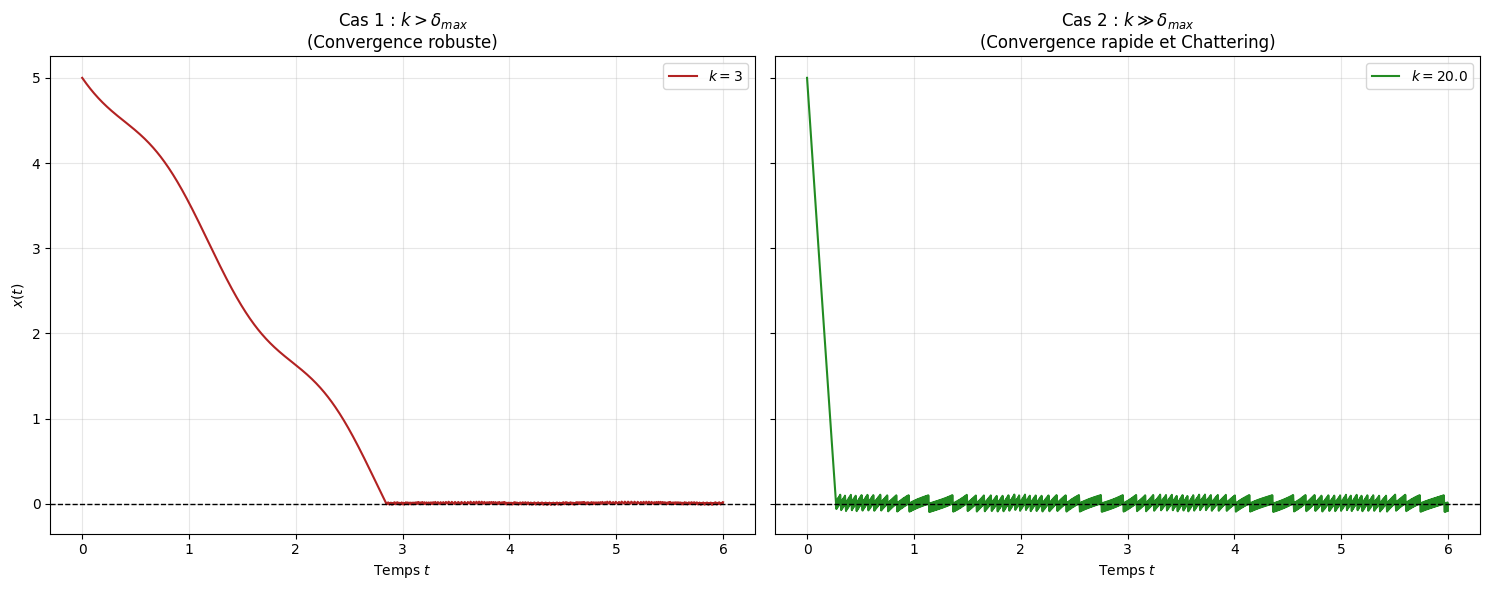

In [10]:
def f_sliding(x, t, k, delta_m):
    d_t = delta_m * (0.6 + 0.4 * np.sin(4 * t)) 
    return -k * np.sign(x) + d_t

x0 = 5.0
delta_m = 2.0
tf = 6.0
dt = 0.005

k1 = 3
t1, sol1 = euler_explicit(lambda x, t: f_sliding(x, t, k1, delta_m), x0, 0, tf, dt)

k2 = 20.0
t2, sol2 = euler_explicit(lambda x, t: f_sliding(x, t, k2, delta_m), x0, 0, tf, dt)

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axs[0].plot(t1, sol1, color='firebrick', label=f'$k={k1}$')
axs[0].axhline(0, color='black', lw=1, ls='--')
axs[0].set_title(f"Cas 1 : $k > \delta_{{max}}$\n(Convergence robuste)")
axs[0].set_xlabel('Temps $t$')
axs[0].set_ylabel('$x(t)$')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(t2, sol2, color='forestgreen', label=f'$k={k2}$')
axs[1].axhline(0, color='black', lw=1, ls='--')
axs[1].set_title(f"Cas 2 : $k \gg \delta_{{max}}$\n(Convergence rapide et Chattering)")
axs[1].set_xlabel('Temps $t$')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Question 7** Illustrer et commenter le comportement du schéma d'Euler explicite autour de 0. On parle de phénomène de chattering. Que se passe-t-il si $k$ est grand ? Proposer un schema d'Euler implicite pour ce système et montrer qu'il permet d'éviter ce *chattering* et d'assurer une convergence numérique exacte vers 0.

---

**Réponse à la question 7**

Autour de $0$, le schéma d’Euler explicite appliqué à $\dot x=-k\,{\rm sign}(x)$ donne
$$x_{n+1}=x_n-k\,dt\,{\rm sign}(x_n).$$
Si $x_n>0$ et $k\,dt>x_n$, alors $x_{n+1}<0$. Au pas suivant, ${\rm sign}(x_{n+1})=-1$ donc
$$x_{n+2}=x_{n+1}+k\,dt>0.$$
On obtient alors des passages de part et d’autre de $0$ à chaque pas (oscillations de signe), ce qu’on appelle chattering. La solution numérique n’adhère pas à $0$ et “claque” autour de $0$.

Si $k$ est grand (à $dt$ fixé), le saut $k\,dt$ est plus grand, donc l’overshoot autour de $0$ est plus important et le chattering est plus marqué. Pour le réduire avec Euler explicite, il faut typiquement diminuer $dt$ quand $k$ augmente.

Un Euler implicite naturel est
$$x_{n+1}=x_n-k\,dt\,{\rm sign}(x_{n+1}).$$
On résout par cas :
- si $x_{n+1}>0$, alors $x_{n+1}=x_n-k\,dt$ et cela exige $x_n>k\,dt$ ;
- si $x_{n+1}<0$, alors $x_{n+1}=x_n+k\,dt$ et cela exige $x_n<-k\,dt$ ;
- si $|x_n|\le k\,dt$, on peut prendre $x_{n+1}=0$ (ce choix est cohérent avec la notion ${\rm sign}(0)\in[-1,1]$).

Donc la mise à jour implicite équivaut à
$$x_{n+1}={\rm sign}(x_n)\max\big(|x_n|-k\,dt,\,0\big).$$
Cela évite le chattering car dès que $|x_n|\le k\,dt$, on obtient exactement $x_{n+1}=0$ et on y reste ensuite : convergence numérique exacte vers $0$ en un nombre fini de pas.


In [6]:
def euler_implicit_sliding(x0,t0,tf,dt):
    
    return time, sol


**Question 8** Application : donner un exemple physique d'un oscillateur évoluant selon
$$
\begin{array}{rcl}
\dot{x}_1 &=& x_2 \\
\dot{x}_2 &=& -x_1 - k {\rm sign}(x_2)  
\end{array}
$$
et proposer un schéma numérique pour simuler son comportement.

In [7]:
def euler_implicit_friction(x0,t0,tf,dt):
    
    return time, sol
